<a href="https://colab.research.google.com/github/Manan1811/UNet-Autoencoder/blob/master/U_Net_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyyaml h5py

In [3]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K

import os
import pickle
import numpy as np
import cv2

In [2]:
!mkdir -p saved_model

##Load Cifar-10 Dataset

In [4]:
batch_size = 50
num_classes = 10
epochs = 100
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape, x_test.shape)

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3) (10000, 32, 32, 3)


In [5]:
# divide x_test into validation and test
x_val = x_test[:7000]
x_test = x_test[7000:]
print("validation data: {0} \ntest data: {1}".format(x_val.shape, x_test.shape))

validation data: (7000, 32, 32, 3) 
test data: (3000, 32, 32, 3)


#Dice Coefficient Loss Function:
It works pretty well for me training a fully DCNN to segment images

In [6]:

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

## UNET AutoEncoder

In [7]:
#Encoding
inputs = Input((32, 32, 3))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)


In [8]:
#Decoding
up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
conv10 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

In [9]:

model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [10]:
es_cb = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
chkpt = 'AutoEncoder_UNET_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
history = model.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, x_val),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

Epoch 1/100
 998/1000 [============================>.] - ETA: 0s - loss: -0.6416 - dice_coef: 0.6416
Epoch 00001: val_loss improved from inf to -0.64628, saving model to AutoEncoder_UNET_weights.01--0.64--0.65.hdf5
1000/1000 [==============================] - 18s 18ms/step - loss: -0.6416 - dice_coef: 0.6416 - val_loss: -0.6463 - val_dice_coef: 0.6463
Epoch 2/100
 997/1000 [============================>.] - ETA: 0s - loss: -0.6424 - dice_coef: 0.6424
Epoch 00002: val_loss did not improve from -0.64628
1000/1000 [==============================] - 18s 18ms/step - loss: -0.6424 - dice_coef: 0.6424 - val_loss: -0.6463 - val_dice_coef: 0.6463
Epoch 3/100
 999/1000 [============================>.] - ETA: 0s - loss: -0.6423 - dice_coef: 0.6423
Epoch 00003: val_loss did not improve from -0.64628
1000/1000 [==============================] - 18s 18ms/step - loss: -0.6423 - dice_coef: 0.6423 - val_loss: -0.6463 - val_dice_coef: 0.6463
Epoch 4/100
 999/1000 [============================>.] - ETA: 

##Evaluate with test dataset

In [11]:
score = model.evaluate(x_test, x_test, verbose=1)
print(score)

94/94 [==============================] - 1s 7ms/step - loss: -0.6429 - dice_coef: 0.6429
[-0.6429439187049866, 0.642928421497345]


In [12]:
c10test = model.predict(x_test)
c10val = model.predict(x_val)

In [13]:
print("Cifar10_test: {0}\nCifar10_val: {1}".format(np.average(c10test), np.average(c10val)))

Cifar10_test: 1.0
Cifar10_val: 1.0


##Visualize original image, semantic segmentation, and gray-scale and RGB histogram

In [14]:
def showOrigDec(orig, dec, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 8))

    for i in range(n):
        # display original
        ax = plt.subplot(4, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i +1 + n)
        plt.imshow(dec[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display histogram
        ax = plt.subplot(4, n, i +1 + n + n)
        plt.hist((orig[i]*255).ravel(),256,[0,256])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)        
        
        ax = plt.subplot(4, n, i +1 + n + n + n)
        color = ('b','g','r')
        for j,col in enumerate(color):
            histr = cv2.calcHist([(orig[i]*255)],[j],None,[256],[0,256])
            plt.plot(histr,color = col)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)    
    plt.show()

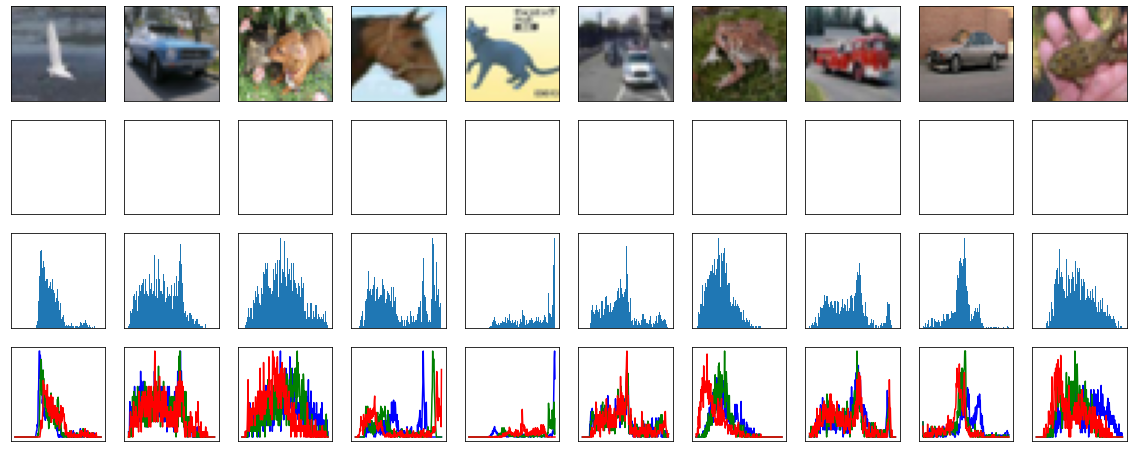

In [15]:
showOrigDec(x_test, c10test)

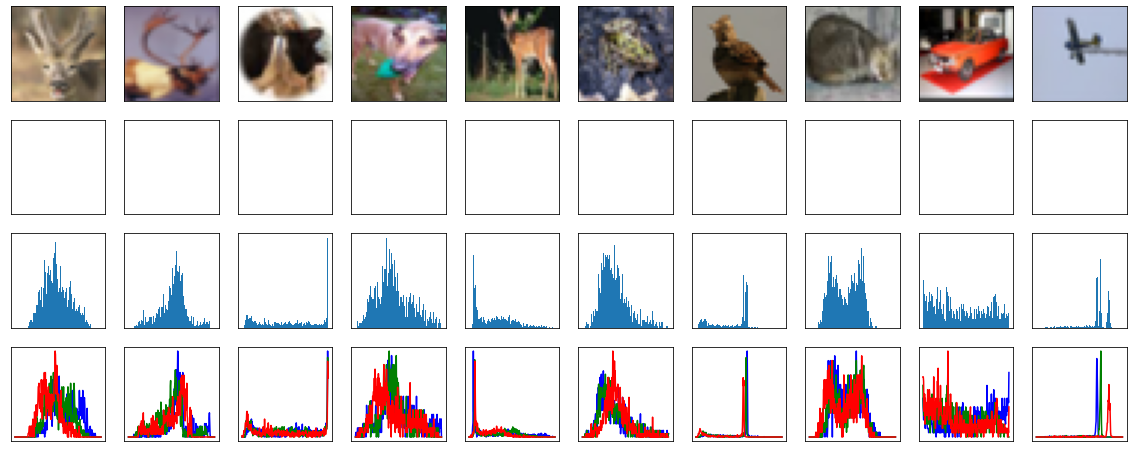

In [16]:
showOrigDec(x_test[200:], c10test[200:])

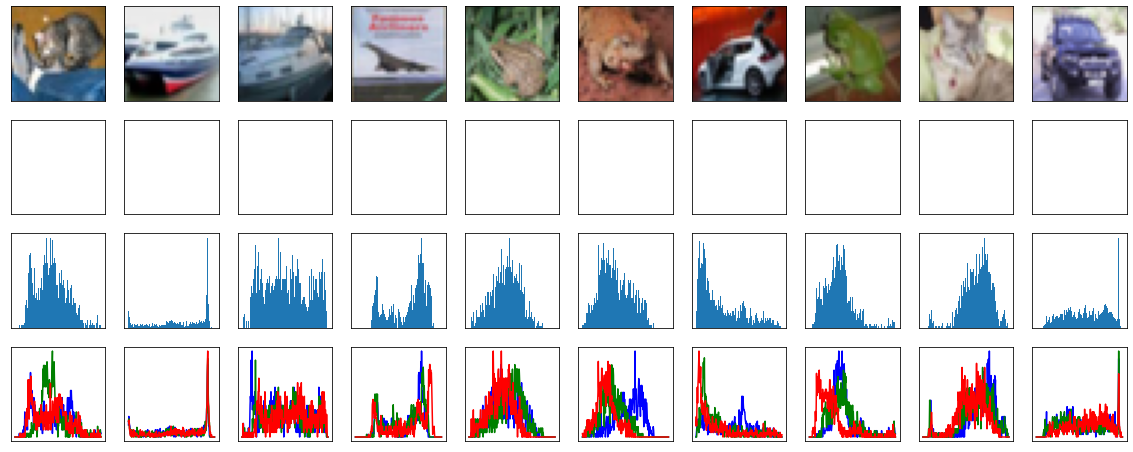

In [17]:
showOrigDec(x_val, c10val)

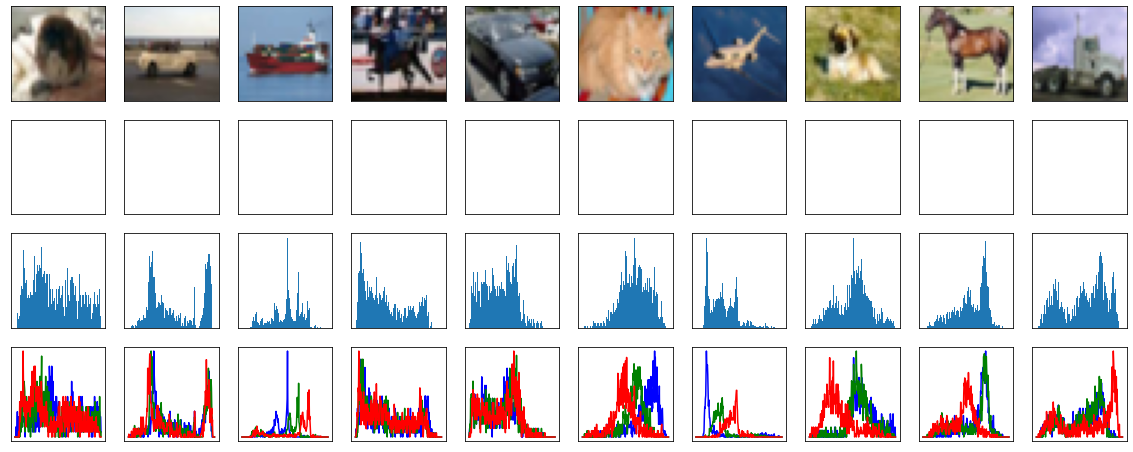

In [18]:
showOrigDec(x_val[200:], c10val[200:])

## Try the UNET AutoEncoder on Cifar100
## Load cifar100 dataset

In [19]:
from keras.datasets import cifar100

(x_train100, y_train100), (x_test100, y_test100) = cifar100.load_data()
# normalize data
x_train100 = x_train100.astype('float32')
x_test100 = x_test100.astype('float32')
x_train100 /= 255
x_test100 /= 255

print('x_train100 shape:', x_train100.shape)
print(x_train100.shape[0], 'train samples')
print(x_test100.shape[0], 'test samples')

score = model.evaluate(x_train100, x_train100, verbose=1)
print(score)

169009152/169001437 [==============================] - 6s 0us/step
x_train100 shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
1563/1563 [==============================] - 9s 6ms/step - loss: -0.6466 - dice_coef: 0.6465
[-0.6465634703636169, 0.6465458273887634]


# Autoencoder on Cifar100 dateset

In [20]:
c100train = model.predict(x_train100)
c100test = model.predict(x_test100)
print("Cifar100 train: {0} \nCifar100 test: {1}"
      .format(np.average(c100train), np.average(c100test)))

Cifar100 train: 1.0 
Cifar100 test: 1.0


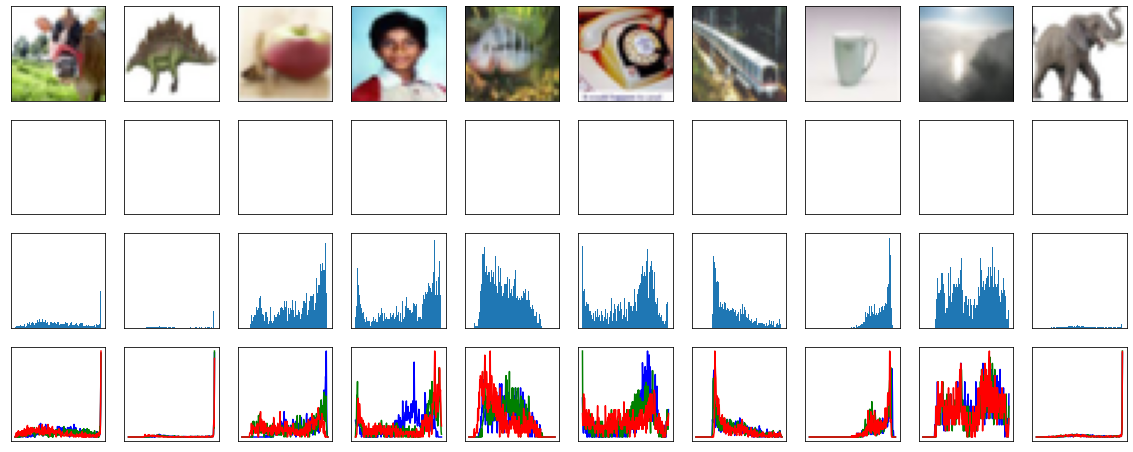

In [21]:
showOrigDec(x_train100, c100train)

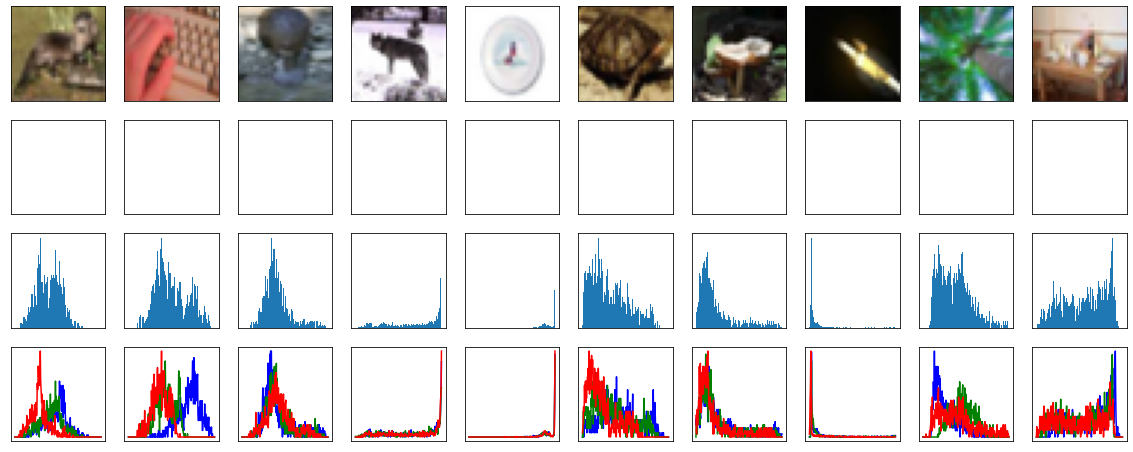

In [22]:
showOrigDec(x_train100[100:], c100train[100:])

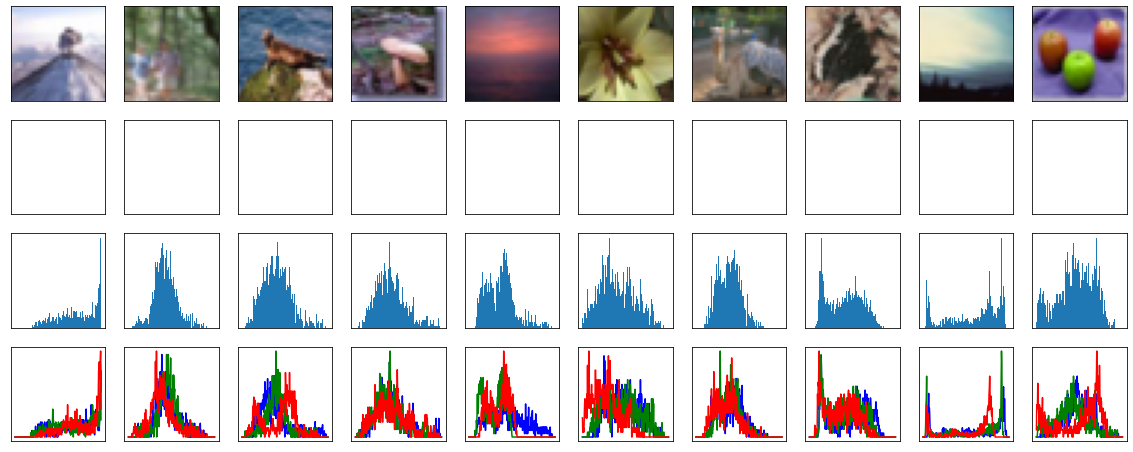

In [23]:
showOrigDec(x_test100, c100test)

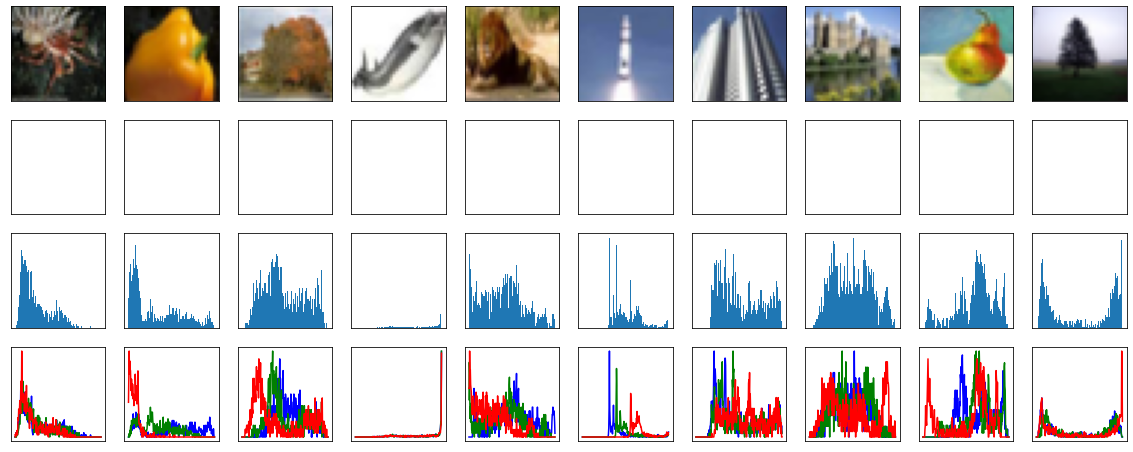

In [24]:

showOrigDec(x_test100[100:], c100test[100:])

In [25]:
!ls AutoEncoder_UNET_weights.01--0.64--0.65.hdf5

AutoEncoder_UNET_weights.01--0.64--0.65.hdf5
